<a href="https://colab.research.google.com/github/homeromolina/Analysis/blob/main/LSTM_IMDB_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

sns.set_style('whitegrid')
np.random.seed(42)
results_path = Path('results', 'sentiment_imdb')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using CPU


# Prepare Data

In [2]:
vocab_size = 20000

In [3]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=42, 
                                                      skip_top=0,
                                                      maxlen=None, 
                                                      oov_char=2, 
                                                      index_from=3,
                                                      num_words=vocab_size)

In [4]:
y_train

array([1, 0, 1, ..., 1, 0, 0])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


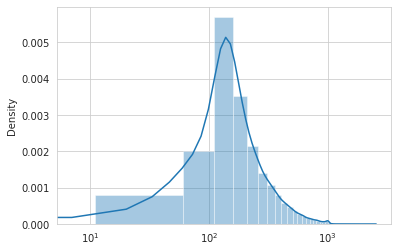

In [5]:
ax = sns.distplot([len(review) for review in X_train])
ax.set(xscale='log');

In [6]:
"""
Esse passo é necessário porque a maioria das redes neurais trabalha com dados numéricos e com formato de matrizes, 
e as sequências de dados de entrada geralmente não possuem o mesmo tamanho. Ao utilizar a função pad_sequences, 
é possível garantir que todas as sequências tenham o mesmo tamanho, permitindo que a rede neural processe esses dados de forma consistente. 
Além disso, ao adicionar padding às sequências curtas, é possível evitar problemas de dimensionalidade durante o treinamento da rede neural.
"""

maxlen = 100

X_train_padded = pad_sequences(X_train, 
                        truncating='pre', 
                        padding='pre', 
                        maxlen=maxlen)

X_test_padded = pad_sequences(X_test, 
                       truncating='pre', 
                       padding='pre', 
                       maxlen=maxlen)

X_train_padded.shape, X_test_padded.shape

((25000, 100), (25000, 100))

# Define Model Architecture

In [7]:
K.clear_session()

> The K.clear_session() function is from the Keras library and it's used to clear the session and release all the resources used by the previous models. This can be useful in cases where you're training multiple models in a single script, and you want to start fresh with a new model, without being affected by the previous one. This function will remove all the nodes from the current default graph, but it won't delete the graph itself.

In [8]:
%%time

embedding_size = 100

rnn = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim= embedding_size, 
              input_length=maxlen),
    GRU(units=32,     # especifica o número de neurônios ocultos na camada
        dropout=0.2, 
        recurrent_dropout=0.2),
    Dense(1, activation='sigmoid') # camada binária, tendo como output sentimento positivou ou negativo
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,012,897
Trainable params: 2,012,897
Non-trainable params: 0
_________________________________________________________________
CPU times: user 554 ms, sys: 19.4 ms, total: 574 ms
Wall time: 572 ms


In [14]:
rnn.compile(loss='binary_crossentropy', 
            optimizer='RMSProp', 
            metrics=['accuracy', 
                     tf.keras.metrics.AUC(name='AUC')])

In [16]:
rnn_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_AUC',
                               mode='max',
                               save_best_only=True)

In [18]:
early_stopping = EarlyStopping(monitor='val_AUC', 
                               mode='max',
                              patience=5,
                              restore_best_weights=True)

> O treinamento para após oito épocas e recuperamos os pesos dos melhores modelos para encontrar um AUC de teste alto de 0,9346

In [21]:
%%time

"""
This code is training a Recurrent Neural Network (RNN) using the 'binary_crossentropy' loss function, 
the RMSProp optimizer, and the metrics 'accuracy' and 'AUC'. The model is then saved to a file specified 
by the 'rnn_path' variable using the 'ModelCheckpoint' callback, with the saving criteria being the maximum 
'val_AUC' and saving only the best model. An 'EarlyStopping' callback is also used with a patience of 5, 
which will stop the training if the validation 'AUC' does not improve for 5 consecutive epochs, and restore the best weights. 
The model is trained on the 'X_train_padded' and 'y_train' data and validated on 'X_test_padded' and 'y_test' data.
"""
training = rnn.fit(X_train_padded,
                   y_train,
                   batch_size=32,
                   epochs=100,
                   validation_data=(X_test_padded, y_test),
                   callbacks=[early_stopping, checkpointer],
                   verbose=1)

Epoch 1/100
782/782 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.7970 - AUC: 0.8837
Epoch 1: val_AUC improved from -inf to 0.93180, saving model to results/sentiment_imdb/lstm.h5
782/782 [==============================] - 70s 86ms/step - loss: 0.4285 - accuracy: 0.7970 - AUC: 0.8837 - val_loss: 0.3715 - val_accuracy: 0.8369 - val_AUC: 0.9318
Epoch 2/100
782/782 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8824 - AUC: 0.9494
Epoch 2: val_AUC improved from 0.93180 to 0.93731, saving model to results/sentiment_imdb/lstm.h5
782/782 [==============================] - 63s 81ms/step - loss: 0.2881 - accuracy: 0.8824 - AUC: 0.9494 - val_loss: 0.3240 - val_accuracy: 0.8582 - val_AUC: 0.9373
Epoch 3/100
782/782 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.9036 - AUC: 0.9638
Epoch 3: val_AUC improved from 0.93731 to 0.93793, saving model to results/sentiment_imdb/lstm.h5
782/782 [==============================] - 65s

In [ ]:
"""
%%time

from tensorflow.distribute import MirroredStrategy

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    rnn = Sequential()
    # ...build your model
    rnn.compile(loss='binary_crossentropy', 
                optimizer='RMSProp', 
                metrics=['accuracy', 
                         tf.keras.metrics.AUC(name='AUC')])
    rnn_path = (results_path / 'lstm.h5').as_posix()
    checkpointer = ModelCheckpoint(filepath=rnn_path,
                                   verbose=1,
                                   monitor='val_AUC',
                                   mode='max',
                                   save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_AUC', 
                                   mode='max',
                                   patience=5,
                                   restore_best_weights=True)

training = rnn.fit(X_train_padded,
                   y_train,
                   batch_size=32,
                   epochs=100,
                   validation_data=(X_test_padded, y_test),
                   callbacks=[early_stopping,
                              callbacks],
verbose=1)
"""

In [14]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Evaluate Results

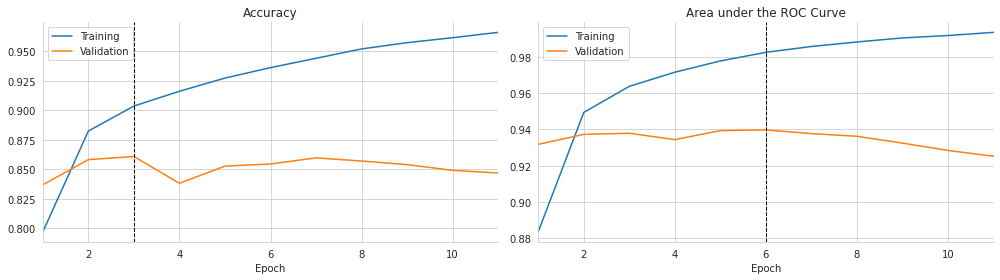

In [31]:
history = pd.DataFrame(training.history)
history.index += 1

fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
df1 = (history[['accuracy', 'val_accuracy']]
.rename(columns={'accuracy': 'Training',
'val_accuracy': 'Validation'}))
df1.plot(ax=axes[0], title='Accuracy', xlim=(1, len(history)))

axes[0].axvline(history.val_accuracy.idxmax(), ls='--', lw=1, c='k')

df2 = (history[['AUC', 'val_AUC']]
.rename(columns={'AUC': 'Training',
'val_AUC': 'Validation'}))
df2.plot(ax=axes[1], title='Area under the ROC Curve', xlim=(1, len(history)))

axes[1].axvline(history.val_AUC.idxmax(), ls='--', lw=1, c='k')

for i in [0, 1]:
  axes[i].set_xlabel('Epoch')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_imdb_cv', dpi=300)

In [27]:
%%time

y_score = rnn.predict(X_test_padded)
y_score.shape

782/782 [==============================] - 10s 13ms/step
CPU times: user 11.8 s, sys: 497 ms, total: 12.3 s
Wall time: 10.3 s


(25000, 1)

In [29]:
%%time
roc_auc_score(y_score=y_score.squeeze(), y_true=y_test)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 18.2 ms


0.940257824